# **Esercitazione 2**
## Blind Search


## **Setup**: GridWorld


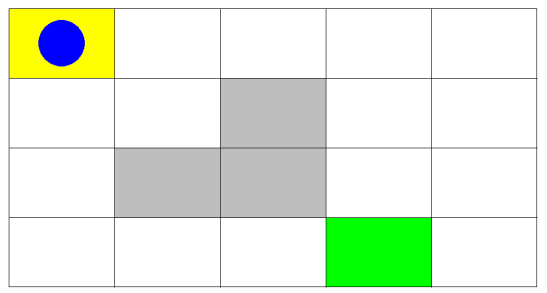



* ## azioni: “N”, “S”, “W”, “E” (tutte a costo 1)
* ## le celle grigie sono inaccessibili
* ## l’agente deve raggiungere la cella verde

### Creiamo il nostro GridWorld

In [1]:
import pygame

class GridWorld:
    def __init__(
            self,
            x_max,
            y_max,
            x_green,
            y_green,
            gray_cells,
            agent,
            omniscent, # whether the agent is also passed x_green and y_green
            forbidden,
    ) -> None:
        self.x_max = x_max
        self.y_max = y_max
        self.x_green = x_green
        self.y_green = y_green
        self.gray_cells = gray_cells
        self.agent = agent
        self.omniscent = omniscent
        self.forbidden = forbidden
        self.x_agent = self.y_agent = 0
        self.success = False

    def transition(self, x, y, action) -> tuple:
        if action is None:
            return x, y
        if action in self.forbidden:
            print(F'warning: forbidden "{action}" ignored!')
            return x, y
        dx, dy = 0, 0
        if action.startswith('N'):
            dy = -1
        elif action.startswith('S'):
            dy = +1
        if action.endswith('E'):
            dx = +1
        elif action.endswith('W'):
            dx = -1
        x1 = max(0, min(self.x_max, x + dx))
        y1 = max(0, min(self.y_max, y + dy))
        invalid = False
        # invalid if crossing a wall
        invalid |= dx != 0 and x1 == x
        invalid |= dy != 0 and y1 == y
        # invalid if trying to get to the gray cell
        invalid |= (x1, y1) in self.gray_cells
        if invalid:
            # restore previous position
            x1, y1 = x, y
        return x1, y1

    def model(self, state, action):
        x, y = state["x"], state["y"]
        return self.transition(x, y, action)

    def goal_test(self, state):
        x, y = state
        return (x, y) == (self.x_green, self.y_green)

    def successor_fn(self, state, include_none, include_diagonal):
        action_space = ["N", "S", "W", "E"]
        if include_diagonal:
            action_space += ["NE", "SE", "NW", "SW"]
        if include_none:
            succs = [(None, tuple(state))]
        else:
            succs = []
        for a in action_space:
            s1 = self.model({"x": state[0], "y": state[1]}, a)
            # invalid actions are not part of the successors
            if not s1 == state:
                succs.append((a, s1))
        return succs

    def cost_fn(self, action):
        if action is None:
            return 0
        elif len(action) == 2:
            return 3
        return 1

    def step(self) -> None:
        #print(f'[env] invoking agent s_agent=({self.x_agent},{self.y_agent})...')
        if self.omniscent:
            action = self.agent(self.x_agent, self.y_agent, self.x_max, self.y_max)
        else:
            action = self.agent(self.x_agent, self.y_agent)
        #print(f'[env] s_agent=({self.x_agent},{self.y_agent}), received action: {action}')
        #print(f'[env] received action: {action}, agent position was: {(self.x_agent,self.y_agent)}')
        if self.goal_test((self.x_agent, self.y_agent)):
            self.success = True
        else:
            self.x_agent, self.y_agent = self.transition(self.x_agent, self.y_agent, action)

    def render(self, screen: pygame.Surface) -> None:
        w, h = screen.get_width(), screen.get_height()
        grid_width = self.x_max + 1
        grid_height = self.y_max + 1
        padding_cells = 1
        cell_width = int(w / (2*padding_cells + grid_width))
        cell_height = int(h / (2*padding_cells + grid_height))
        x_pad, y_pad = cell_width*padding_cells, cell_height*padding_cells
        agent_size = goal_size = (2/3)*min(cell_height, cell_width)
        # clear the screen
        screen.fill("white")
        # draw the gray cells
        for (x_gray, y_gray) in self.gray_cells:
            pygame.draw.rect(
                screen,
                color="gray",
                rect=pygame.Rect(
                    x_pad + x_gray*cell_width,
                    y_pad + y_gray*cell_height,
                    cell_width,
                    cell_height
                )
            )
        # draw the start cell
        pygame.draw.rect(
            screen,
            color="yellow",
            rect=pygame.Rect(
                    x_pad,
                    y_pad,
                    cell_width,
                    cell_height
            )
        )
        # draw the goal cell
        pygame.draw.rect(
            screen,
            color="green",
            rect=pygame.Rect(
                    x_pad + self.x_green*cell_width,
                    y_pad + self.y_green*cell_height,
                    cell_width,
                    cell_height
            )
        )
        # draw the grid borders
        pygame.draw.rect(
            screen,
            color="black",
            rect=pygame.Rect(x_pad, y_pad, cell_width*grid_width, cell_height*grid_height),
            width=1,
        )
        # draw cell borders
        for i in range(grid_width-1):
            pygame.draw.line(
                screen,
                color="black",
                start_pos=[x_pad + (i+1)*cell_width, y_pad],
                end_pos=[x_pad + (i+1)*cell_width, y_pad + grid_height*cell_height]
            )
        for i in range(grid_height-1):
            pygame.draw.line(
                screen,
                color="black",
                start_pos=[x_pad, y_pad + (i+1)*cell_height],
                end_pos=[x_pad + grid_width*cell_width, y_pad + (i+1)*cell_height]
            )
        # draw the agent
        x_agent_screen = cell_width/2 + (padding_cells + self.x_agent)*cell_width
        y_agent_screen = cell_height/2 + (padding_cells + self.y_agent)*cell_height
        pygame.draw.circle(
            screen,
            color="blue",
            center=[x_agent_screen, y_agent_screen],
            radius=agent_size/2,
        )

pygame 2.5.2 (SDL 2.28.3, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Codice per visualizzare l'agente che si muove nel mondo

In [2]:
def run_env(env, search_algo, include_none, include_diagonal):
    assert env.agent is None

    sol_node = search_algo(
        initial_state=(env.x_agent, env.y_agent),
        goal_test=env.goal_test,
        successor_fn=lambda s: env.successor_fn(s, include_none=include_none, include_diagonal=include_diagonal),
        cost_fn=env.cost_fn,
    )
    if sol_node is None:
        raise ValueError(f'No solution found.')
    sol = sol_node.to_solution()
    cost = sol_node.path_cost
    print(f'Found solution (cost: {cost}): {sol}')
    rev_sol = list(reversed(sol))
    env.agent = lambda x, y: rev_sol.pop() if len(rev_sol) > 0 else None

    print(f'Executing solution...')

    # pygame setup
    pygame.init()
    screen = pygame.display.set_mode((1280, 720))
    clock = pygame.time.Clock()
    running = True
    frames_per_step = 50 # determines speed of rendering
    frames = 1
    env.render(screen=screen)

    while running and not env.success:
        # poll for events
        # pygame.QUIT event means the user clicked X to close your window
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # advance world by one time step and render it to screen
        if frames % frames_per_step == 0:
            env.step()
            env.render(screen=screen)
        frames += 1

        # flip() the display to put your work on screen
        pygame.display.flip()

        clock.tick(60)  # limits FPS to 60

    pygame.quit()

    if env.success:
        print(f'The agent reached the goal successfully!')
    else:
        print(f"The agent did NOT reach the goal.")

### Definiamo la classe 'Node' che rappresenterà i nodi del nostro State Space

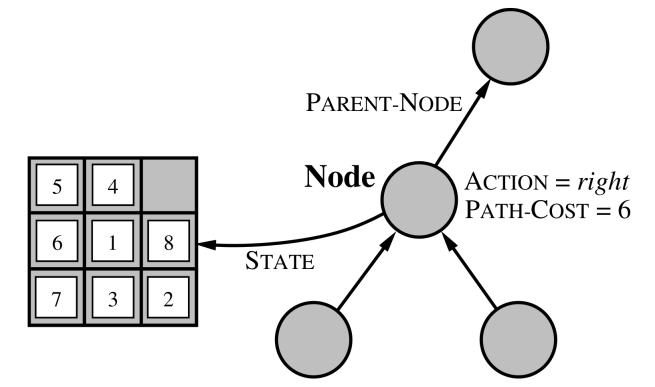

In [3]:
class Node:

    def __init__(self, state, path_cost=0, action=None, parent=None):
        self.state = state
        self.path_cost = path_cost
        self.action = action
        self.parent = parent

    def to_solution(self):
        seq = []
        node = self
        s0 = None
        while node is not None:
            if node.parent is None:
                s0 = node.state
            if node.action is not None and node.parent is not None:
                seq.append(node.action)
            node = node.parent
        assert s0 is not None
        return list(reversed(seq))

    def __repr__(self):
        s = f'Node(state={self.state}, path_cost={self.path_cost}, action={self.action}'
        s += ')' if self.parent is None else f', parent={self.parent.state})'
        return s

## **Algoritmi di ricerca non informata**

### **Breadth-First Search**
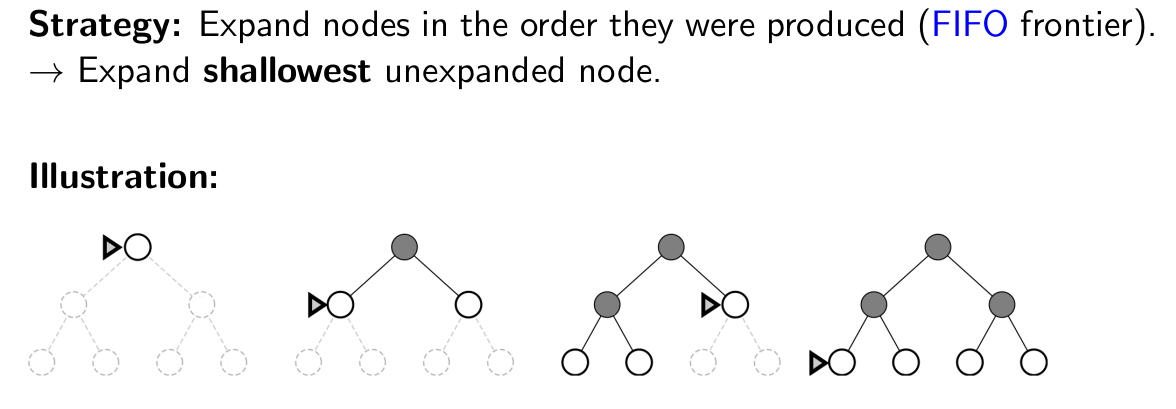

### **Depth-First Search**
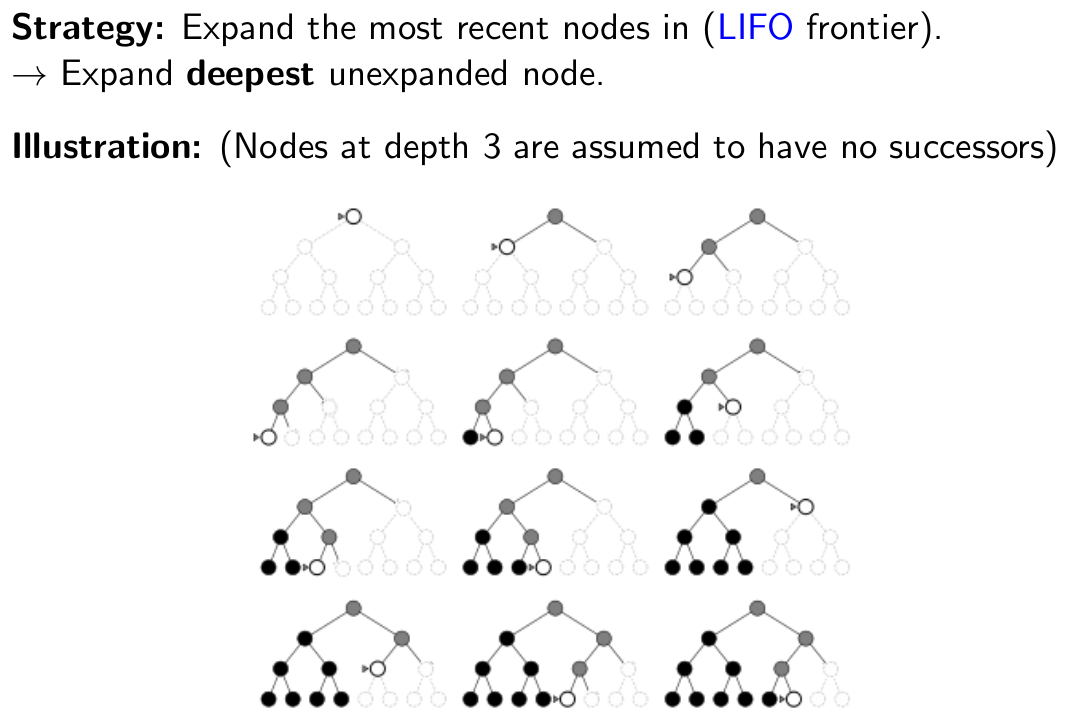

### **Uniform-Cost Search**
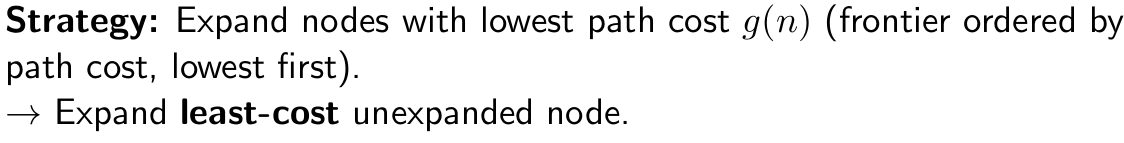

## **Esercizio 1**:
### A) Quali sono il maximum branching factor e la profondità della soluzione? Calcolare le risultanti complessità di spazio e tempo (worst case) di breadth-first search
O($b^d$) per il tempo e spazio


### B) La soluzione trovata da breadth-first search è sempre ottima per ogni configurazione di start, goal e celle grigie (assumendo che la soluzione esista)?
### Motivare la risposta
Se il costo è sempre unitario allora è sempre ottima

### C) Se si aggiungessero le azioni diagonali, ognuna di costo c > 2, sarebbe ancora garantita l’ottimalità della soluzione ritornata da breadth-first search?
### Motivare la risposta
Se fosse uguale a due allora il movimento diagonale sarebbe equivalente a muoversi unariamente su x e y. Poiché è maggiore di due non vale l'equivalenza e quindi la breadth-first search non sarebbe ottima

### D) Implementare breadth-first search (completare codice)

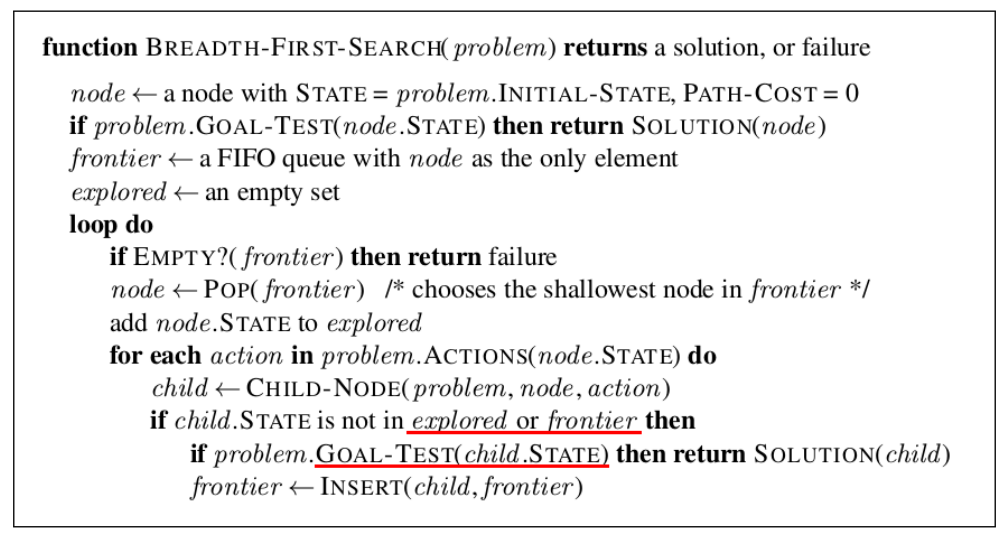

In [12]:
# PARAMETRI E VALORE DI RITORNO DELLE FUNZIONI DA IMPLEMENTARE
# ------------------------------------------------------------
#
# - initial_state: tupla (x, y) con lo stato iniziale dell'agente
# - goal_test: funzione da usare come "goal_test(s)" che ritorna un
#   booleano che indica se lo stato s = (x, y) è di goal o meno
# - successor_fn: funzione da usare come "successor_fn(s)", che ritorna
#   una lista di tuple (a, s1) con i successori dello stato s, dove a
#   è l'azione presa per arrivare a s1 da s
# - cost_fn: funzione da usare come "cost_fn(a)" che ritorna il costo
#   dell'azione a
#
# La funzione deve ritornare l'ultimo nodo della soluzione
# (un oggetto di tipo Node).

def breadth_first_search(
    initial_state,
    goal_test,
    successor_fn,
    cost_fn
):
    node = Node(initial_state, 0)
    if goal_test(node.state):
        return node
    frontier = [] #has to be FIFO with node as the only element
    frontier.append(node)
    explored = [] #empty set
    while True:
        if len(frontier) == 0:
            return None
        node = frontier.pop(0)
        explored.append(node.state)
        lista_azioni_stati = successor_fn(node.state)
        for action, next_state in lista_azioni_stati:
            child = Node(state=next_state, parent=node, action=action)
            if child not in explored or child not in frontier:
                if goal_test(child.state):
                    return child
                frontier.append(child)


In [13]:
env = GridWorld(
        x_max=4,
        y_max=3,
        x_green=3,
        y_green=3,
        gray_cells=[(2, 1), (1, 2), (2, 2)],
        agent=None,
        omniscent=False,
        forbidden=["NE", "NW", "SE", "SW"]
    )
print(f'Running breadth-first search...')
run_env(env, breadth_first_search, include_none=False, include_diagonal=False)

Running breadth-first search...
Node(state=(3, 3), path_cost=Node(state=(2, 3), path_cost=Node(state=(1, 3), path_cost=Node(state=(0, 3), path_cost=Node(state=(0, 2), path_cost=Node(state=(0, 1), path_cost=Node(state=(0, 0), path_cost=0, action=None), action=S), action=S), action=S), action=E), action=E), action=E)
Found solution (cost: Node(state=(2, 3), path_cost=Node(state=(1, 3), path_cost=Node(state=(0, 3), path_cost=Node(state=(0, 2), path_cost=Node(state=(0, 1), path_cost=Node(state=(0, 0), path_cost=0, action=None), action=S), action=S), action=S), action=E), action=E)): []
Executing solution...
The agent did NOT reach the goal.


: 

## **Esercizio 2**:
### Setting: lo stesso dell'esercizio 1
### A) Implementare la variante appropriata di depth-first search (completare codice)
### ATTENZIONE: tra l'implementazione (naive) di DFS e BFS l'unica cosa che cambia è la gestione della frontiera (FIFO vs LIFO) <----

In [4]:
# PARAMETRI E VALORE DI RITORNO DELLE FUNZIONI DA IMPLEMENTARE
# ------------------------------------------------------------
#
# - initial_state: tupla (x, y) con lo stato iniziale dell'agente
# - goal_test: funzione da usare come "goal_test(s)" che ritorna un
#   booleano che indica se lo stato s = (x, y) è di goal o meno
# - successor_fn: funzione da usare come "successor_fn(s)", che ritorna
#   una lista di tuple (a, s1) con i successori dello stato s, dove a
#   è l'azione presa per arrivare a s1 da s
# - cost_fn: funzione da usare come "cost_fn(a)" che ritorna il costo
#   dell'azione a
#
# La funzione deve ritornare l'ultimo nodo della soluzione
# (un oggetto di tipo Node).

def depth_first_search(
    initial_state,
    goal_test,
    successor_fn,
    cost_fn
):
    node = Node(state=initial_state, path_cost=0)
    if goal_test(node.state):
        return node
    frontier = [node] #has to be FIFO with node as the only element
    explored = set() #empty set
    while True:
        if len(frontier) == 0:
            return None
        node = frontier.pop()
        explored.add(node.state)
        lista_azioni_stati = successor_fn(node.state)
        for action, next_state in lista_azioni_stati:
            child = Node(state=next_state, parent=node, action=action)
            if child.state not in explored and child not in frontier:
                if goal_test(child.state):
                    return child
                frontier.append(child)


In [5]:
env = GridWorld(
    x_max=4,
    y_max=3,
    x_green=3,
    y_green=3,
    gray_cells=[(2, 1), (1, 2), (2, 2)],
    agent=None,
    omniscent=False,
    forbidden=["NE", "NW", "SE", "SW"]
)
print(f'Running depth-first search...')
run_env(env, depth_first_search, include_none=False, include_diagonal=False)

Running depth-first search...


KeyboardInterrupt: 

### B) Nel caso in cui la griglia non abbia confini, è ancora garantita la completezza con depth-first search?

## **Esercizio 3**:
### Setting: lo stesso dell'esercizio 1, ma disponibili anche azioni diagonali (costo c > 2)
### A) Qual è il limite inferiore al costo di ogni azione e il costo della soluzione ottima per la configurazione data? Calcolare le risultanti complessità di spazio e tempo (worst case) di uniform cost search
### B) La completezza di uniform cost search su alberi è garantita per ogni configurazione di start, goal e celle grigie (assumendo esista una soluzione)?
### Motivare la risposta
### C) Se si aggiungesse l’azione None (nessun movimento, costo 0), sarebbe ancora garantita la completezza di uniform-cost search su alberi?
### Motivare la risposta

### D) Implementare uniform cost search (completare codice)

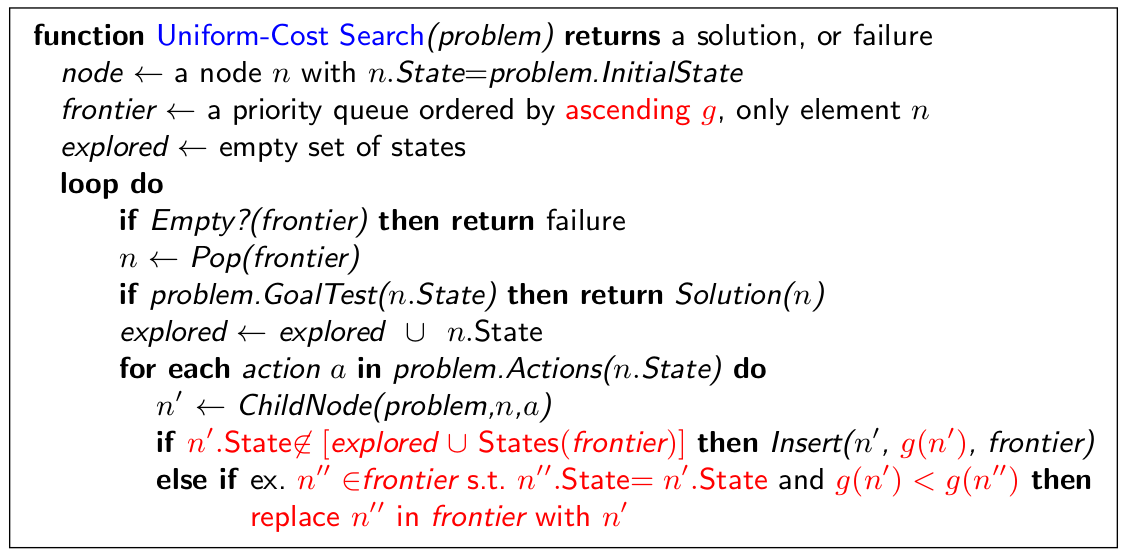

In [ ]:
# PARAMETRI E VALORE DI RITORNO DELLE FUNZIONI DA IMPLEMENTARE
# ------------------------------------------------------------
#
# - initial_state: tupla (x, y) con lo stato iniziale dell'agente
# - goal_test: funzione da usare come "goal_test(s)" che ritorna un
#   booleano che indica se lo stato s = (x, y) è di goal o meno
# - successor_fn: funzione da usare come "successor_fn(s)", che ritorna
#   una lista di tuple (a, s1) con i successori dello stato s, dove a
#   è l'azione presa per arrivare a s1 da s
# - cost_fn: funzione da usare come "cost_fn(a)" che ritorna il costo
#   dell'azione a
#
# La funzione deve ritornare l'ultimo nodo della soluzione
# (un oggetto di tipo Node).

def uniform_cost_search(
    initial_state,
    goal_test,
    successor_fn,
    cost_fn
):
    pass


In [ ]:
env = GridWorld(
        x_max=4,
        y_max=3,
        x_green=3,
        y_green=3,
        gray_cells=[(2, 1), (1, 2), (2, 2)],
        agent=None,
        omniscent=False,
        forbidden=[]
    )
print(f'Running uniform-cost search...')
run_env(env, uniform_cost_search, include_none=False, include_diagonal=True)